In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pykalman import KalmanFilter

In [12]:
# file = pd.read_csv("AAPL_price.csv", dtype={"Close" : np.float64, "Open":np.float64, "High":np.float64, "Low":np.float64, "Volume":np.float64})
# dataframe = file.iloc[1:, :] #Delete first row
data = pd.read_csv("AAPL_price.csv")
data.head()

,Date,Close,Open,High,Low,Volume
0,1980-12-12,0.13,0.13,0.13,0.13,469030000.0
1,1980-12-15,0.12,0.12,0.12,0.12,175880000.0
2,1980-12-16,0.11,0.11,0.11,0.11,105730000.0
3,1980-12-17,0.12,0.12,0.12,0.12,86440000.0
4,1980-12-18,0.12,0.12,0.12,0.12,73450000.0


In [13]:
#Data Cleasning
# Ensure no null value exist
data.dropna(inplace=True)
print(data.isnull().sum())	# Must be 0
print(data.count())

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64
Date      10325
Close     10325
Open      10325
High      10325
Low       10325
Volume    10325
dtype: int64


In [14]:
# Ensure there are no duplicates
data.drop_duplicates(subset='Date', inplace=True)
print(data.count())

Date      10325
Close     10325
Open      10325
High      10325
Low       10325
Volume    10325
dtype: int64


In [19]:
closePrice = data.Close.astype("float32")
train = closePrice[0:int(len(closePrice)*0.8)]

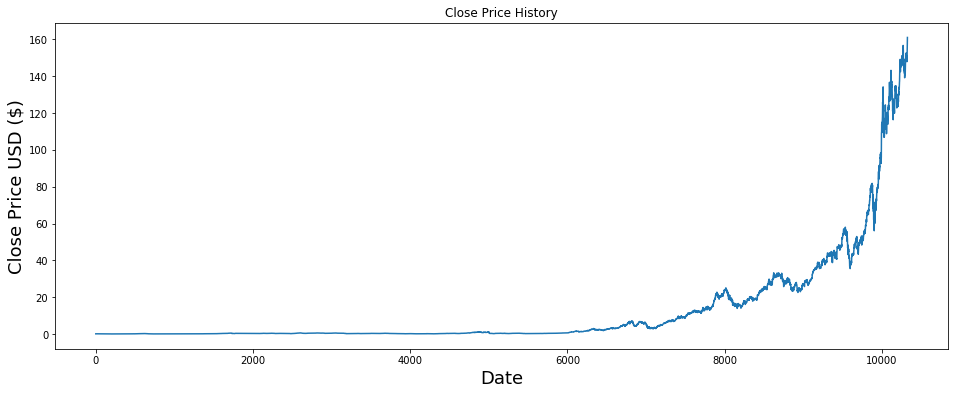

In [8]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(file['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [27]:
#Data normalization
#We have to sacle our data for optimal performance
sc = MinMaxScaler(feature_range = (-1,1))
training_set_scaled = sc.fit(train.values.reshape(-1,1))
closePrice = sc.transform(closePrice.values.reshape(-1,1))


In [30]:
'''
Our train data will have as features the look back values, which are the lag values noted as ‘lb’.
For this example, we set the lb equal to 10. Notice that we scale the data on the “train” dataset
using the MinMaxScaler() from scikit-learn. Finally, for this example, we keep as train dataset
the first 90% of the observations and as a test dataset the rest 10%
'''
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(closePrice,lb)
X,y = processData(closePrice,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

9282 10
1032 10
9282
1032


In [31]:
#Need to install Tensorflow
#pip install --upgrade tensorflow
#pip install keras
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),shuffle=False)
model.summary() 


Epoch 1/100
291/291 [==============================] - 9s 22ms/step - loss: 0.0104 - val_loss: 5.2399
Epoch 2/100
291/291 [==============================] - 5s 16ms/step - loss: 0.0026 - val_loss: 7.5514
Epoch 3/100
291/291 [==============================] - 5s 17ms/step - loss: 0.0016 - val_loss: 4.9266
Epoch 4/100
291/291 [==============================] - 6s 20ms/step - loss: 0.0013 - val_loss: 3.0335
Epoch 5/100
291/291 [==============================] - 5s 17ms/step - loss: 0.0017 - val_loss: 1.4755
Epoch 6/100
291/291 [==============================] - 5s 17ms/step - loss: 0.0022 - val_loss: 0.6926
Epoch 7/100
291/291 [==============================] - 5s 17ms/step - loss: 0.0027 - val_loss: 0.4512
Epoch 8/100
291/291 [==============================] - 6s 21ms/step - loss: 0.0031 - val_loss: 0.3875
Epoch 9/100
291/291 [==============================] - 6s 21ms/step - loss: 0.0032 - val_loss: 0.4369
Epoch 10/100
291/291 [==============================] - 6s 21ms/step - loss: 0.003

291/291 [==============================] - 5s 17ms/step - loss: 4.0201e-04 - val_loss: 2.8180
Epoch 79/100
291/291 [==============================] - 5s 17ms/step - loss: 4.7837e-04 - val_loss: 2.0767
Epoch 80/100
291/291 [==============================] - 5s 17ms/step - loss: 4.4785e-04 - val_loss: 4.1354
Epoch 81/100
291/291 [==============================] - 5s 17ms/step - loss: 4.7401e-04 - val_loss: 3.8997
Epoch 82/100
291/291 [==============================] - 5s 17ms/step - loss: 5.0708e-04 - val_loss: 8.5193
Epoch 83/100
291/291 [==============================] - 5s 17ms/step - loss: 5.4904e-04 - val_loss: 2.9522
Epoch 84/100
291/291 [==============================] - 5s 17ms/step - loss: 5.9111e-04 - val_loss: 2.3087
Epoch 85/100
291/291 [==============================] - 5s 17ms/step - loss: 6.2231e-04 - val_loss: 1.1286
Epoch 86/100
291/291 [==============================] - 5s 17ms/step - loss: 6.0366e-04 - val_loss: 0.8116
Epoch 87/100
291/291 [============================

Text(0.5, 1.0, 'Train Dataset')

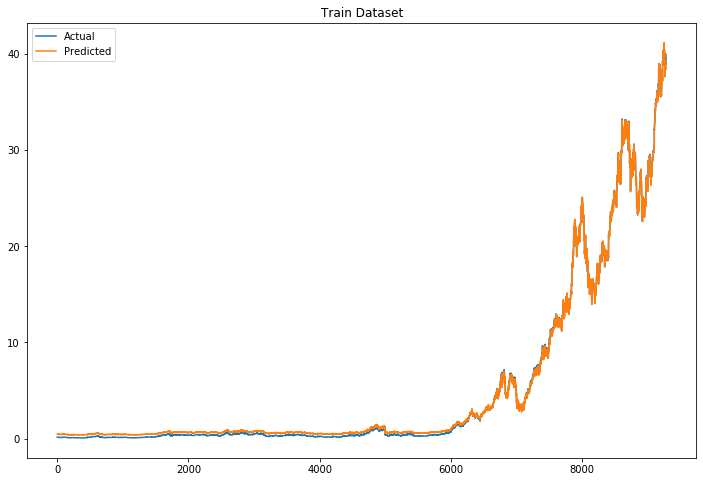

In [32]:
plt.figure(figsize=(12,8))
 
Xt = model.predict(X_train)
plt.plot(sc.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(sc.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")